In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import sklearn
import xgboost as xgb
import optuna
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn import svm

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report,f1_score

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
#nltk.download('wordnet')
#conda install -c conda-forge wordcloud

# Data Preparation
## Data Collected from https://www.yelp.com/dataset/download
## File size for Yelp Review - 6.94 GB
## 1 Million records were extracted from the JSON and converted to CSV

In [3]:
row_size = 1000000
json_path_4_review = './yelp_academic_dataset_review.json'
df = pd.read_json(json_path_4_review, lines=True,
                 dtype={'review_id':str,'name':str,
                        'business_id':str,'stars':int,
                        'date':str,'text':str,'useful':int,
                        'funny':int,'cool':int},
                  chunksize=row_size)

In [4]:
train_datasets = []
dev_datasets = []
test_datasets = []
i=0
for chunk in df:
    if i==0:
        train_datasets.append(chunk)
    else:
        break;
    i=i+1

train_dataset = pd.concat(train_datasets, ignore_index=True, join='outer', axis=0)   

In [5]:
# Create trimmed dataset with 1 million records

In [6]:
train_dataset.to_csv('yelp_academic_dataset_review.csv')

In [7]:
## Reading the dataset with 1 million records and splitting them in train and test set
## Added this file creation since we were toggling between Local jupyter notebook, Kaggle and Colab. 
## So created the trimmed file created for portability and for reduced resource utilization

In [8]:
train_dataset=pd.read_csv('./yelp_academic_dataset_review.csv')

In [12]:
def sentimentGrouping(s):
    if (s >= 4):
        rating=1
    elif (s == 3):
        rating=0
    else:
        rating=-1
    
    return rating

#Restaurant Ratings 
print("Restaurant Ratings",pd.unique(train_dataset['stars']))
print("No. of Reviews for each rating:\n",pd.value_counts(train_dataset['stars']))

train_dataset['Sentiments'] = train_dataset.apply(lambda x: sentimentGrouping(x['stars']), axis=1)

X = train_dataset["text"]
y = train_dataset["Sentiments"]

#X,y = shuffle(X,y)

train_data, dev_data, train_labels, dev_labels = train_test_split(X, y, test_size=0.2)


Restaurant Ratings [4 5 2 1 3]
No. of Reviews for each rating:
 5    438341
4    225903
1    144169
3    109154
2     82433
Name: stars, dtype: int64


##Let's Consider Rating 4 & 5 - Positive
##Let's Consider Rating 3 - Neutral
##Let's Consider Rating 1 & 2 - Negative

In [13]:
#Negative Sentiments
neg_phrases = train_dataset[train_dataset.Sentiments == -1]
neg_words = []
for t in neg_phrases.text:
    neg_words.append(t)
negative_words = pd.Series(neg_words).str.cat(sep=' ')

#Positive Sentiments
positive_phrases = train_dataset[train_dataset.Sentiments == 1]
positive_words = []
for t in positive_phrases.text:
    positive_words.append(t)
pos_words = pd.Series(positive_words).str.cat(sep=' ')

#Neutral Sentiments
neutral_phrases = train_dataset[train_dataset.Sentiments == 0]
neutral_words = []
for t in neutral_phrases.text:
    neutral_words.append(t)
neu_words = pd.Series(neutral_words).str.cat(sep=' ')

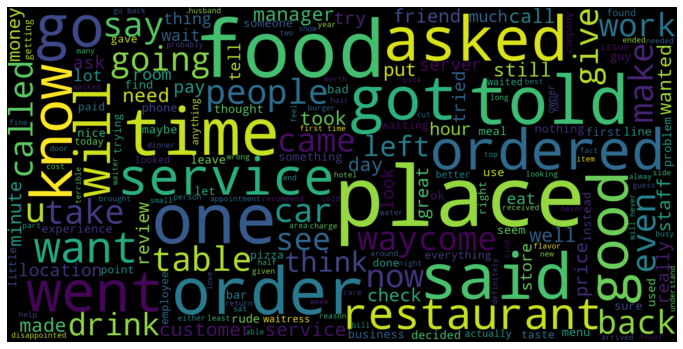

In [14]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(negative_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neu_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
## Logistic Regression Model used for the text classification without any hyperparameter tuning

In [ ]:
vector = CountVectorizer(analyzer='word', stop_words='english')

X_train = vector.fit_transform(train_data)

tfidf_transformer = TfidfTransformer()
train_tfidf = tfidf_transformer.fit_transform(X_train)

X_dev = vector.transform(dev_data)
dev_tfidf = tfidf_transformer.transform(X_dev)

lr_clf = LogisticRegression(C=0.5,solver="liblinear", multi_class="auto",penalty="l2",tol=0.015)
lr_clf.fit(train_tfidf, train_labels)

dev_labels_pred = lr_clf.predict(X_dev)
    
#mse = np.sqrt(sum((dev_labels - dev_labels_pred) ** 2))
#print("Accuracy for Model Logistic Regression is %f" % ( accuracy))
print("F1 score is %f" % (f1_score(dev_labels, dev_labels_pred, average='weighted')))
#print("Number of vocabulary: ",len(vector_reduced.vocabulary_))

print(classification_report(dev_labels,dev_labels_pred))
print("Accuracy of Logistic Regression without Hyperparameter Tuning: %f" % (accuracy_score(dev_labels,dev_labels_pred)))

In [ ]:
print("Number of vocabulary: ",len(vector.vocabulary_))

In [ ]:
#Model Parameter tuning
#Trying different Regularization Strength for L1 and L2 simultaneously
#Using L1 regression to reduce the vocabulary
#Applying L2 regression on the reduced Vocabulary

In [ ]:

c=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


f1_score_lst = []
vocabularies = []

for val in c:
        
    vector = CountVectorizer(analyzer='word', stop_words='english')
    X_train = vector.fit_transform(train_data)
    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(X_train)
    
    lr_clf = LogisticRegression(C=val,solver="liblinear", multi_class="auto", penalty="l1",tol=.015)
    lr_clf.fit(train_tfidf, train_labels)

    features = vector.get_feature_names()

    feature_dict = {}
    feature_zero = []
    vocabulary_exclude=[]

    #Get the feature and increment them for each topic if they're zero
    for topic in range(lr_clf.coef_.shape[0]):
      for feature in range(lr_clf.coef_.shape[1]): 
        if (lr_clf.coef_[topic][feature] == 0):
            feature_dict[feature] = feature_dict.get(feature,0) + 1

    #Identify the vocabs for the features which are 0 coef for all stars
    #and exclude them
    for feature in feature_dict:
      if feature_dict[feature] == lr_clf.coef_.shape[0]:
        feature_zero.append(feature)
        vocabulary_exclude.append(features[feature])

    vector_reduced = CountVectorizer(analyzer='word',stop_words=vocabulary_exclude)
    X_train = vector_reduced.fit_transform(train_data)
    X_dev = vector_reduced.transform(dev_data)
    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(X_train)
    dev_tfidf = tfidf_transformer.fit_transform(X_dev)

    lr_clf_2 = LogisticRegression(C=val,solver="liblinear", multi_class="auto", penalty="l2",tol=.015)
    lr_clf_2.fit(train_tfidf, train_labels)

    dev_labels_pred = lr_clf_2.predict(dev_tfidf)

    print("Regularization strength for L1 and L2 : ",val)
    print("F1 score is %f" % (f1_score(dev_labels, dev_labels_pred, average='weighted')))
    len_vocab = len(vector_reduced.vocabulary_)
    log_vocab = np.log(len_vocab)
    print("Number of vocabulary: ",len(vector_reduced.vocabulary_))
    print("Accuracy %f" % accuracy_score(dev_labels,dev_labels_pred))
    
    
    f1_score_lst.append(f1_score(dev_labels, dev_labels_pred, average='weighted'))
    vocabularies.append(log_vocab)
        

plt.figure(figsize=(15,5))

plt.plot(f1_score_lst, vocabularies)
plt.title("F1 Score vs Log of vocabulary for L1 regression with reduced Vocabulary")
plt.xlabel('F1 Score')
plt.ylabel('Log of vocabulary')

In [ ]:
#Performing lemmatization and regularization

In [ ]:


def preprocessor_custom(doc):
    
    new_doc = str(doc)
    
    new_doc = re.sub(r'[^A-Za-z\s]',r' ',new_doc)

    new_doc = " ".join([w.lower() for w in new_doc.split()])
    
    wordnet_lemmatizer = WordNetLemmatizer()
    new_doc = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in new_doc.split()])
    
    return new_doc

c=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]


f1_score_lst = []
vocabularies = []

for val in c:

    vector = CountVectorizer(analyzer='word', preprocessor=preprocessor_custom)
    X_train = vector.fit_transform(train_data)
    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(X_train)

    lr_clf = LogisticRegression(C=val,solver="liblinear", multi_class="auto", penalty="l1",tol=.015)
    lr_clf.fit(train_tfidf, train_labels)

    features = vector.get_feature_names()

    feature_dict = {}
    feature_zero = []
    vocabulary_exclude=[]

    #Get the feature and increment them for each topic if they're zero
    for topic in range(lr_clf.coef_.shape[0]):
      for feature in range(lr_clf.coef_.shape[1]): 
        if (lr_clf.coef_[topic][feature] == 0):
            feature_dict[feature] = feature_dict.get(feature,0) + 1

    #Identify the vocabs for the features which are 0 coef for all stars
    #and exclude them
    for feature in feature_dict:
      if feature_dict[feature] == lr_clf.coef_.shape[0]:
        feature_zero.append(feature)
        vocabulary_exclude.append(features[feature])

    vector_reduced = CountVectorizer(analyzer='word', stop_words=vocabulary_exclude)
    X_train = vector_reduced.fit_transform(train_data)
    X_dev = vector_reduced.transform(dev_data)
    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(X_train)
    dev_tfidf = tfidf_transformer.fit_transform(X_dev)

    lr_clf_2 = LogisticRegression(C=val,solver="liblinear", multi_class="auto", penalty="l1",tol=.015)
    lr_clf_2.fit(train_tfidf, train_labels)

    dev_labels_pred = lr_clf_2.predict(dev_tfidf)

    print("F1 score is %f" % (f1_score(dev_labels, dev_labels_pred, average='weighted')))
    len_vocab = len(vector_reduced.vocabulary_)
    log_vocab = np.log(len_vocab)
    print("Number of vocabulary: ",len(vector_reduced.vocabulary_))
    print("C Value for L1 and L2: ",val)
    print("Accuracy %f" % accuracy_score(dev_labels,dev_labels_pred))
    f1_score_lst.append(f1_score(dev_labels, dev_labels_pred, average='weighted'))
    vocabularies.append(log_vocab)

plt.figure(figsize=(15,5))

plt.plot(f1_score_lst, vocabularies)
plt.title("F1 Score vs Log of vocabulary for L1 and L2 regression with reduced Vocabulary")
plt.xlabel('F1 Score')
plt.ylabel('Log of vocabulary')

In [ ]:
#Best values for Logistic Regression

In [ ]:
#Performing Classification using XGBoost

In [ ]:
xc=XGBClassifier(n_estimators=1000)
xc.fit(train_tfidf, train_labels)

xc_labels_pred = xc.predict(dev_tfidf)

print("F1 score is %f" % (f1_score(dev_labels, xc_labels_pred, average='weighted')))
len_vocab = len(vector_reduced.vocabulary_)
log_vocab = np.log(len_vocab)
print("Number of vocabulary: ",len(vector_reduced.vocabulary_))
print("C Value for L1 and L2: ",val)
f1_score_lst.append(f1_score(dev_labels, xc_labels_pred, average='weighted'))
print("Accuracy %f" % accuracy_score(dev_labels,xc_labels_pred))
vocabularies.append(log_vocab)

plt.figure(figsize=(15,5))

plt.plot(f1_score_lst, vocabularies)
plt.title("F1 Score vs Log of vocabulary for L1 and L2 regression with reduced Vocabulary")
plt.xlabel('F1 Score')
plt.ylabel('Log of vocabulary')

In [ ]:
#Performing Classification using Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rc=RandomForestClassifier(n_estimators=1000)

In [ ]:
rc.fit(train_tfidf, train_labels)

rc_labels_pred = rc.predict(dev_tfidf)

print("F1 score is %f" % (f1_score(dev_labels, rc_labels_pred, average='weighted')))
len_vocab = len(vector_reduced.vocabulary_)
log_vocab = np.log(len_vocab)
print("Number of vocabulary: ",len(vector_reduced.vocabulary_))
print("C Value for L1 and L2: ",val)
f1_score_lst.append(f1_score(dev_labels, rc_labels_pred, average='weighted'))
print("Accuracy of Random Forest Classifier Model %f" % accuracy_score(dev_labels,rc_labels_pred))

vocabularies.append(log_vocab)

plt.figure(figsize=(15,5))

plt.plot(f1_score_lst, vocabularies)
plt.title("F1 Score vs Log of vocabulary for L1 and L2 regression with reduced Vocabulary")
plt.xlabel('F1 Score')
plt.ylabel('Log of vocabulary')

In [ ]:
#Performing Classification using Support Vector Machine 

In [ ]:
svc=svm.SVC()

In [ ]:
param={'kernel':('linear','rbf'),'C':[1,10]}

In [ ]:
sv=GridSearchCV(svc,param)

In [ ]:
sv.fit(train_tfidf, train_labels)

In [ ]:
sorted(sv.cv_results_.keys())

In [ ]:
sv_labels_pred=sv.predict(dev_tfidf)
print("F1 score is %f" % (f1_score(dev_labels, sv_labels_pred, average='weighted')))
len_vocab = len(vector_reduced.vocabulary_)
log_vocab = np.log(len_vocab)
print("Number of vocabulary: ",len(vector_reduced.vocabulary_))
print("C Value for L1 and L2: ",val)
f1_score_lst.append(f1_score(dev_labels, sv_labels_pred, average='weighted'))
print("Accuracy of Support Vector Machine Model %f" % accuracy_score(dev_labels,sv_labels_pred))
vocabularies.append(log_vocab)

plt.figure(figsize=(15,5))

plt.plot(f1_score_lst, vocabularies)
plt.title("F1 Score vs Log of vocabulary for L1 and L2 regression with reduced Vocabulary")
plt.xlabel('F1 Score')
plt.ylabel('Log of vocabulary')


In [ ]:

def objective(trial):
    
    
    dtrain = xgb.DMatrix(train_tfidf, label=train_labels)
    dtest = xgb.DMatrix(dev_tfidf, label=dev_labels)

    param = {
        
        "objective": "multi:softmax",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        "num_class":3,
        }

    if param["booster"] == "gbtree":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
  

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial,"validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)
   
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(dev_labels, pred_labels)
    return accuracy


In [ ]:
#Naive bayes Classifier

In [ ]:
model_NB = MultinomialNB()
model_NB.fit(train_tfidf, train_labels) 

dev_labels_pred = model_NB.predict(dev_tfidf)
print("Accuracy for Model MultinomialNB, is %f" % (accuracy_score(dev_labels, dev_labels_pred)))
print(classification_report(dev_labels,dev_labels_pred))

In [ ]:
lc=LabelEncoder()

In [ ]:
train_labels=lc.fit_transform(train_labels)

In [ ]:
dev_labels=lc.transform(dev_labels)

In [ ]:
study = optuna.create_study(direction="maximize")

In [ ]:
study.optimize(objective, n_trials=5)
print(study.best_trial)

In [ ]:
# Using Convolution Neural Network for Text Classification

In [ ]:
%%capture
!pip install wandb

In [ ]:
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, Flatten, MaxPooling1D

import wandb
from wandb.keras import WandbCallback

# Initialize wandb with your project name
run = wandb.init(project='sentiment-analysis',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 5,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "YELP Reviews"
                 })

config = wandb.config
config.vocab_size = 1000
config.maxlen = 1000
config.batch_size=32
config.embedding_dims = 10
config.filters = 16
config.kernel_size = 3
config.hidden_dims = 250
config.epochs = 10


In [ ]:
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, Flatten, MaxPooling1D

import wandb
from wandb.keras import WandbCallback

# Initialize wandb with your project name
run = wandb.init(project='sentiment-analysis',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 5,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "CIFAR-10"
                 })

config = wandb.config
config.vocab_size = 1000
config.maxlen = 1000
config.batch_size=32
config.embedding_dims = 10
config.filters = 16
config.kernel_size = 3
config.hidden_dims = 250
config.epochs = 10

tokenizer = text.Tokenizer(num_words=config.vocab_size)
tokenizer.fit_on_texts(train_data)

X_train = tokenizer.texts_to_matrix(train_data)
X_test = tokenizer.texts_to_matrix(dev_data)

X_train = sequence.pad_sequences(X_train, maxlen=config.maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=config.maxlen)

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
Lr=LabelEncoder()
Lr.fit(train_labels)
train_l=Lr.transform(train_labels)
test_l=Lr.transform(dev_labels)

train_l=np_utils.to_categorical(train_l)

model = Sequential()
model.add(Embedding(config.vocab_size, config.embedding_dims, input_length=config.maxlen))
model.add(Dropout(0.5))

model.add(Conv1D(config.filters,config.kernel_size,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(config.filters,config.kernel_size,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(config.hidden_dims,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[['acc','auc']])
history = model.fit(X_train, train_l, batch_size=config.batch_size, epochs=config.epochs)


preds=model.predict(X_test)
preds=np.argmax(preds,1)
from sklearn.metrics import accuracy_score
print("Accuracy of CNN %f : " % (accuracy_score(test_l, preds)))